In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.patches as patches
import numpy as np
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import cartopy.crs as ccrs
import xml.etree.ElementTree as ET

## Functions

In [2]:
def equi_filled(map_axis, centerlon, centerlat, radius, color, alpha=1.0):
    """
    Modified from the ipmag function equi().
    """
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = ipmag.shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
    
    X = X[::-1]
    Y = Y[::-1]
    
    XY = np.stack([X,Y],axis=1)
    
    circle_edge = patches.Polygon(XY,
                                  edgecolor=color,facecolor='none',
                                  transform=ccrs.Geodetic())
    circle_face = patches.Polygon(XY,
                                  edgecolor='none',facecolor=color,alpha=alpha,
                                  transform=ccrs.Geodetic())
    
    map_axis.add_patch(circle_face)
    map_axis.add_patch(circle_edge)

In [3]:
def get_craton_XYs(gpml, plateIDs):
    """
    Get XY coordinates of a plate polygon from a .gpml.
    
    Parameters
    ----------
    gpml : string
        Path to .gpml file.
        
    plateIDs : list
        Of plateIDs.
    """
    # namespace dictionary
    ns = {'gpml':'http://www.gplates.org/gplates',
          'gml':'http://www.opengis.net/gml'}
    
    # initial parse
    tree = ET.parse(gpml)
    root = tree.getroot()
    
    # storage
    Xs = []
    Ys = []
    
    # iterate through featureMembers
    for featureMember in root.findall('gml:featureMember',ns):
        
        # get child
        for child in featureMember:
            slice_ind = child.tag.find('}')
            child_root = 'gpml:' + child.tag[slice_ind+1:]
        
        # check plateID
        plateID_path = child_root + '/gpml:reconstructionPlateId/gpml:ConstantValue/gpml:value'
        feature_plateID = int(featureMember.find(plateID_path,ns).text)
        if feature_plateID in plateIDs:
            
            if featureMember.find(child_root + '/gpml:outlineOf', ns)!=None:
                polygon_root = child_root + '/gpml:outlineOf'
            elif featureMember.find(child_root + '/gpml:boundary', ns)!=None:
                polygon_root = child_root + '/gpml:boundary'
            elif featureMember.find(child_root + '/gpml:unclassifiedGeometry', ns)!=None:
                polygon_root = child_root + '/gpml:unclassifiedGeometry'
            elif featureMember.find(child_root + '/gpml:centerLineOf', ns)!=None:
                polygon_root = child_root + '/gpml:centerLineOf'
            else:
                raise Exception('polygon_root undefined.')
            
            # get coordinates
            posList_path = polygon_root + '/gpml:ConstantValue/gpml:value/gml:Polygon/gml:exterior/gml:LinearRing/gml:posList'
            feature_posList = np.fromstring(featureMember.find(posList_path,ns).text, dtype=float, sep=' ')
            
            # split into lat and lon
            lat_inds = np.arange(0, len(feature_posList), 2, dtype=int)
            lon_inds = np.arange(1, len(feature_posList), 2, dtype=int)
            
            feature_lat = feature_posList[lat_inds]
            feature_lon = feature_posList[lon_inds]
            
            Xs.append(feature_lon)
            Ys.append(feature_lat)
            
    return Xs, Ys

In [4]:
def craton_plot(ax, plateIDs, Eulers, edgecolor, facecolor, alpha):
    """
    Plot cratons with rotation.
    
    Parameters
    ----------
    ax : map axis
        On which to plot.
    
    plateIDs : list
        Of plateIDs.
        
    Eulers : list of lists
        Of Euler rotation parameters - if more than one given,
        the rotations will be additive.
    """
    # get cratons from .gpml
    gpml = '../../../Rodinia_Model/Merdith-modified/shapes/shapes_cratons.gpml'
    Xs, Ys = get_craton_XYs(gpml, plateIDs)
    
    # rotate cratons
    rotated_Xs = []
    rotated_Ys = []
    for i in range(len(Xs)):
        rotated_X = np.array([])
        rotated_Y = np.array([])
        for j in range(len(Xs[i])):
            this_X = [Xs[i][j]]
            this_Y = [Ys[i][j]]
            for k in range(len(Eulers)):
                this_Y, this_X = pmag.pt_rot(Eulers[k], this_Y, this_X)
            rotated_X = np.append(rotated_X, this_X)
            rotated_Y = np.append(rotated_Y, this_Y)
        rotated_Xs.append(rotated_X)
        rotated_Ys.append(rotated_Y)
        
    # add cratons
    for i in range(len(rotated_Xs)):
        XY = np.stack([rotated_Xs[i][::-1],rotated_Ys[i][::-1]],axis=1)
        poly_edge = patches.Polygon(XY,
                                    edgecolor=edgecolor,facecolor='none',
                                    transform=ccrs.Geodetic())
        poly_face = patches.Polygon(XY,
                                    edgecolor='none',facecolor=facecolor,alpha=alpha,
                                    transform=ccrs.Geodetic())
        ax.add_patch(poly_face)
        ax.add_patch(poly_edge)

In [5]:
def rotated_pole_plot(ax, plon, plat, a95, Eulers, marker, s, marker_color, a95_color, a95_alpha):
    """
    Plot paleomagnetic pole with rotation.
    """
    # rotate pole
    rotated_plat = plat
    rotated_plon = plon
    for i in range(len(Eulers)):
        rotated_plat, rotated_plon = pmag.pt_rot(Eulers[i], [rotated_plat], [rotated_plon])
        rotated_plat = rotated_plat[0]
        rotated_plon = rotated_plon[0]
    
    # degrees to km conversion
    a95_km = a95 * 111.32
    
    # pole
    ax.scatter(rotated_plon, rotated_plat, marker=marker,
               color=marker_color, edgecolors='k', s=s,
               label='__nolegend__', zorder=101, transform=ccrs.Geodetic())
    
    # a95
    equi_filled(ax, rotated_plon, rotated_plat, a95_km, a95_color, alpha=a95_alpha)

## Poles

In [6]:
SChina = pd.read_csv('../../../Rodinia_Model/Merdith-modified/poles/SChina-poles.csv')
SChina

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,slon,dec,inc,dir_a95,pole ref,age ref,grade,note,plateID
0,Yanbian Dikes Group A,SChina,824.0,830.00,818.0,45.100000,130.400000,19.000000,1.0,26.886,101.546,NaN,NaN,NaN,Niu et al. (2016),Niu et al. (2016),B,-,602
1,"Xiaofeng Dikes (recalculated in Jing et al., 2...",SChina,821.0,821.84,820.9,26.100000,82.100000,14.587666,1.0,30.960,111.230,266.5,76.300000,8.2,Li et al. (2004),Wang et al. (2016),B,-,602
2,Banxi Group - all site mean (f=1.0),SChina,815.0,815.00,815.0,51.700000,99.900000,12.441865,1.0,27.910,108.820,346.7,77.000000,6.9,this study,this study,NR,-,602
3,Banxi Group - all site mean (f=0.6),SChina,815.0,815.00,815.0,43.000000,104.000000,8.199390,0.6,27.910,108.820,346.8,82.000000,4.3,this study,this study,NR,-,602
4,Madiyi Formation (f=1.0),SChina,801.9,808.20,795.6,35.300000,67.900000,5.084290,1.0,27.500,109.600,293.1,69.900000,3.2,Xian et al. (2020),Xian et al. (2020),NR,-,602
5,Madiyi Formation (f=0.6),SChina,801.9,808.20,795.6,34.300000,82.400000,3.798684,0.6,27.500,109.600,293.0,77.300000,2.1,Xian et al. (2020),Xian et al. (2020),NR,-,602
6,Chengjiang Formation (f=1.0),SChina,799.5,807.90,791.1,33.400000,56.100000,8.060397,1.0,25.145,102.411,291.9,66.700000,5.2,Jing et al. (2019),Jing et al. (2019),NR,-,602
7,Chengjiang Formation (f=0.6),SChina,799.5,807.90,791.1,32.174324,72.194462,9.140768,0.6,25.145,102.411,291.9,75.511641,5.2,Jing et al. (2019),Jing et al. (2019),NR,-,602
8,Liantuo Formation (f=1.0),SChina,748.0,760.00,736.0,12.700000,157.400000,5.108816,1.0,30.819,111.069,102.5,62.400000,3.7,Jing et al. (2015),Ma et al. (1984),B,-,602
9,Liantuo Formation (f=0.6),SChina,748.0,760.00,736.0,19.585641,144.483489,6.190200,0.6,30.819,111.069,102.5,72.584798,3.7,Jing et al. (2015),Ma et al. (1984),B,-,602


In [7]:
dikes = ['Yanbian Dikes Group A','Xiaofeng Dikes (recalculated in Jing et al., 2019)']

SChina_10 = SChina[SChina['f']==1]
SChina_10.reset_index(drop=True, inplace=True)

SChina_06 = SChina[(SChina['f']==0.6) | (SChina['name'].isin(dikes))]
SChina_06.reset_index(drop=True, inplace=True)
SChina_06

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,slon,dec,inc,dir_a95,pole ref,age ref,grade,note,plateID
0,Yanbian Dikes Group A,SChina,824.0,830.00,818.0,45.100000,130.400000,19.000000,1.0,26.886,101.546,NaN,NaN,NaN,Niu et al. (2016),Niu et al. (2016),B,-,602
1,"Xiaofeng Dikes (recalculated in Jing et al., 2...",SChina,821.0,821.84,820.9,26.100000,82.100000,14.587666,1.0,30.960,111.230,266.5,76.300000,8.2,Li et al. (2004),Wang et al. (2016),B,-,602
2,Banxi Group - all site mean (f=0.6),SChina,815.0,815.00,815.0,43.000000,104.000000,8.199390,0.6,27.910,108.820,346.8,82.000000,4.3,this study,this study,NR,-,602
3,Madiyi Formation (f=0.6),SChina,801.9,808.20,795.6,34.300000,82.400000,3.798684,0.6,27.500,109.600,293.0,77.300000,2.1,Xian et al. (2020),Xian et al. (2020),NR,-,602
4,Chengjiang Formation (f=0.6),SChina,799.5,807.90,791.1,32.174324,72.194462,9.140768,0.6,25.145,102.411,291.9,75.511641,5.2,Jing et al. (2019),Jing et al. (2019),NR,-,602
5,Liantuo Formation (f=0.6),SChina,748.0,760.00,736.0,19.585641,144.483489,6.190200,0.6,30.819,111.069,102.5,72.584798,3.7,Jing et al. (2015),Ma et al. (1984),B,-,602


## Plot

APWP (f=1.0):

In [8]:
lat_grid=[-80,-60,-30,0,30,60,80]
lon_grid=np.arange(-180,180+60,60)

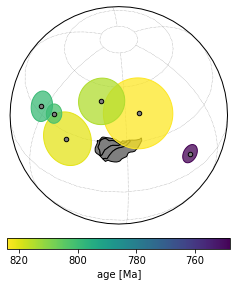

In [9]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=115, central_latitude=45,
                                 figsize=(5,5), grid_lines=False)

craton_plot(ax, [6024], [[0,0,0]], 'k', 'C7', 1.0)
craton_plot(ax, [6023], [[0,0,0]], 'k', 'C7', 1.0)
craton_plot(ax, [602], [[0,0,0]], 'k', 'C7', 1.0)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_10['age']),
                                                         vmax=np.max(SChina_10['age'])))
colors = color_mapping.to_rgba(SChina_10['age']).tolist()

for i in range(len(SChina_10)):
    rotated_pole_plot(ax, SChina_10['plon'][i], SChina_10['plat'][i], SChina_10['a95'][i], [[0,0,0]],
                      'o', 20, 'C7', colors[i], 0.75)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_APWP_f_10.pdf', bbox_inches='tight')
plt.show()

APWP (f=0.6):

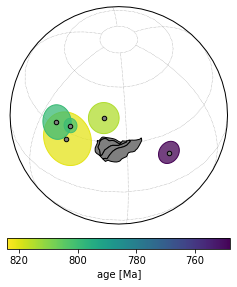

In [10]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=115, central_latitude=45,
                                 figsize=(5,5), grid_lines=False)

craton_plot(ax, [6024], [[0,0,0]], 'k', 'C7', 1.0)
craton_plot(ax, [6023], [[0,0,0]], 'k', 'C7', 1.0)
craton_plot(ax, [602], [[0,0,0]], 'k', 'C7', 1.0)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_06['age']),
                                                         vmax=np.max(SChina_06['age'])))
colors = color_mapping.to_rgba(SChina_06['age']).tolist()

for i in range(1,len(SChina_06)):
    rotated_pole_plot(ax, SChina_06['plon'][i], SChina_06['plat'][i], SChina_06['a95'][i], [[0,0,0]],
                      'o', 20, 'C7', colors[i], 0.75)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_APWP_f_06.pdf', bbox_inches='tight')
plt.show()

Reconstructed South China (f=0.6):

In [11]:
# rotate SChina to India
SChina_India_Euler = [1.98, 74.44, 40.29]

# India rotations
India_Eulers = [[-47.7165, -59.0837, 80.611],
                [-50.9342, -61.1068, 78.6732],
                [-41.4357, -66.6919, 82.8756],
                [-66.5449, -2.2428, 80.9054]]

India_Eulers_ages = [821, 814, 801, 748]

# India rotations to plot the poles
India_Eulers_pole = [[-47.7165, -59.0837, 80.611],
                     [-50.9342, -61.1068, 78.6732],
                     [-41.4357, -66.6919, 82.8756],
                     [-41.4357, -66.6919, 82.8756],
                     [-66.5449, -2.2428, 80.9054]]

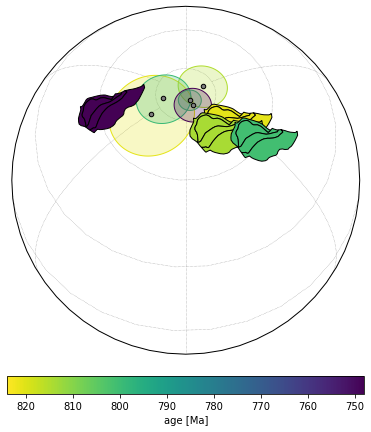

In [12]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=60, central_latitude=60,
                                 figsize=(8,8), grid_lines=False)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_06['age']),
                                                         vmax=np.max(SChina_06['age'])))
pole_colors = color_mapping.to_rgba(SChina_06['age']).tolist()
craton_colors = color_mapping.to_rgba(India_Eulers_ages).tolist()

for i in range(1, len(SChina_06)):
    rotated_pole_plot(ax, SChina_06['plon'][i], SChina_06['plat'][i], SChina_06['a95'][i],
                      [SChina_India_Euler,India_Eulers_pole[i-1]],
                      'o', 20, 'C7', pole_colors[i], 0.25)

for i in range(len(India_Eulers)):
    craton_plot(ax, [6024], [SChina_India_Euler,India_Eulers[i]], 'k', craton_colors[i], 1.0)
    craton_plot(ax, [6023], [SChina_India_Euler,India_Eulers[i]], 'k', craton_colors[i], 1.0)
    craton_plot(ax, [602], [SChina_India_Euler,India_Eulers[i]], 'k', craton_colors[i], 1.0)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_reconstructed.pdf', bbox_inches='tight')
plt.show()